<H1>Sentiment Analysis: Amazon Reviews</H1>
<H3>By Michael Klear</H3><br>
This sentiment analysis project uses <a href='http://jmcauley.ucsd.edu/data/amazon/'>this dataset</a> of Amazon product reviews. I try to make predictions of star ratings based on content of review.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import coo_matrix
import xgboost as xgb
from sklearn.model_selection import cross_val_score

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_json('./rVG5.json', lines=True)
df = df.sample(frac=1, random_state=111)

This is a simple dataset, with just a handful of important columns:

In [3]:
df.head(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
133556,B002FQM5OG,"[0, 0]",2,"Even though I've had this kit for awhile, it d...","03 28, 2010",AKCZIJ6ZHE41D,"Jarucia Jaycox ""~A Pink American""",Not so Good Drum Kit,1269734400
211868,B009CCTSIM,"[1, 1]",5,This thing is long enough to comfortably play ...,"01 24, 2013",A1OXMAQIY6JUI9,J. Thompson,It's a piece of stretched copper... IT WORKS,1358985600


<H2>Outcome Variable:</H2>
The goal is to classify "positive" and "negative" reviews based on the content of the review text. Since there are five ratings, I need to decide what star rating to count as positive and what star ratings to count as negative. Here's the ratings distribution:

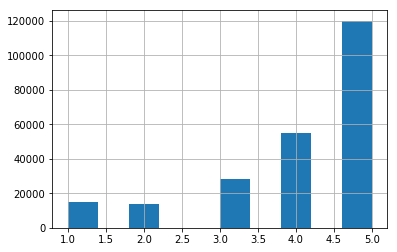

In [4]:
df.overall.hist();
plt.show();

In [5]:
#A peek at a four star rating: clearly positive
df[df.overall==4].iloc[7].reviewText

"I'm not sure which one I like more, this game or Yoshi's Cookie. Both have different rules of gameplay, but both are also challenging. I've always been a sucker for Tetris-style games (pieces fall down, you try to get rid of them) For a NES game, the controls and graphics were smooth. There's not much I can say that other reviewers haven't already said. If you like puzzle games, you should enjoy this."

Four and five star ratings are clearly positive, while three is unclear and often neutral. Based on the idea that 3 ratings don't usually encourage readers to purchase the product, I'll call all four and five star reviews "positive," (1) and group all others as "negative" (or zero).

In [6]:
df['pos'] = np.where(df.overall > 2, 1, 0)
class_imb = 1-(df.pos.sum()/len(df))
print('proportion of negative ratings: ', class_imb)

0.123030459919


We see that most ratings, about 88%, are positive. This gives us a slight class imbalance that could tip our model in favor of positive ratings.<br>
<h2>Features</h2><br>
I build a few features.

The tfidf vectorizer helps us impliment a "bag of words" model of the text in reviews:

In [8]:
#Initialize and train vectorizer on corpus
#Parameters chosen after some tinkering. More tinkering can probably improve model performance.
tv = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', min_df=.00001, max_df=.9)
tv.fit(df.reviewText)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1e-05,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

I'll also hand build some features:

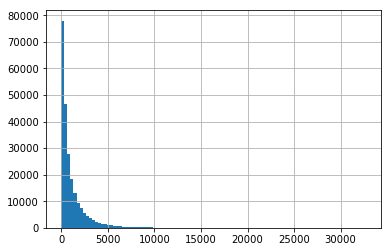

In [9]:
#Convert text to lower case characters
df['reviewText'] = df.reviewText.str.lower()

#Measure the length of review text in number of characters
df['review_length'] = df.reviewText.apply(len)

#Record the number of people who found review helpful
df['helpful_clicks'] = df.helpful.apply(lambda x: x[1])

def get_help_rating(helpful):
    """Rates helpfulness based on overall number of clicks. Returns zero if zero
    total clicks. If every click found unhelpful, returns negative value (number of unhelpful
    clicks)
    """
    if helpful[1] == 0:
        return 0
    elif helpful[1] > 0:
        if helpful[0] == 0:
            return -helpful[1]
        else:
            return helpful[0]/helpful[1]
    
#Get helpful rating
df['helpful_rating'] = df.helpful.apply(get_help_rating)
#Get length of summary
df['summary_length'] = df.summary.apply(len)

df.review_length.hist(bins=100);
plt.title('Distribution of review lengths');
plt.xlabel('Review Length (characters)');
plt.show(); #See the distribution of review lengths

In [10]:
features = tv.transform(df.reviewText)
features #See how many features we've got... Over one million!!

<231780x1192329 sparse matrix of type '<class 'numpy.float64'>'
	with 30091877 stored elements in Compressed Sparse Row format>

<H2>Holdout Group</H2><br>
To evaluate our model, we'll reserve 20% of our samples in a holdout group.

In [11]:
cutoff = int(.8 * len(df))

ft = [                #Pick hand-built features
    'review_length',
    'helpful_clicks',
    'helpful_rating',
    'summary_length'
]


train = df[:cutoff]
ft_train = scipy.sparse.hstack((features[:cutoff], np.array(df[ft][:cutoff]))) #Add my features to sparse matrix

test = df[cutoff:]
ft_test = scipy.sparse.hstack((features[cutoff:], np.array(df[ft][cutoff:]))) #Repeat for training set

#Define outcome variable
Y_train = train.pos
Y_test = test.pos

In [17]:
#Take a look at imbalance of test set for evaluation comparison
print('test set imbalance: ', Y_test.sum()/len(Y_test))

test set imbalance:  0.876779704893


<H2>Model: XGBoost</H2><br>
XGBoost is a great algorithm for this problem. It can efficiently work with the sparse features and pick up on subtle interactions between features.

In [ ]:
#Convert data to xgb datamatrices
dtrain = xgb.DMatrix(ft_train, label=Y_train)
dtest = xgb.DMatrix(ft_test, label=Y_test)

In [21]:
#Set up our model for training. Parameters chosen after much tinkering.
param = {
    'max_depth': 7, 
    'eta': 1,  #Notice high eta and max depth. Helps work with vast number of features
    'silent': 0, 
    'objective': 
    'binary:logistic', 
    'scale_pos_weight': (class_imb),  #Tell model about class imbalance
    'nthread':4,
    'eval_metric':'error'
}

plst = param.items()
num_round = 500
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(plst, dtrain, num_round, evallist) #We can watch outputs to see model slowly optimize.
#Breaks 90% accuracy at around 410 iterations, with vanishing returns around 500.

Y_ = np.where(bst.predict(dtrain)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_train)
print(tb)
print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

Y_ = np.where(bst.predict(dtest)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_test)
print(tb)
print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

[0]	eval-error:0.269566	train-error:0.262215
[1]	eval-error:0.224653	train-error:0.217626
[2]	eval-error:0.225904	train-error:0.219465
[3]	eval-error:0.213025	train-error:0.204413
[4]	eval-error:0.208107	train-error:0.198567
[5]	eval-error:0.203987	train-error:0.193351
[6]	eval-error:0.197213	train-error:0.186033
[7]	eval-error:0.194452	train-error:0.182118
[8]	eval-error:0.193136	train-error:0.178887
[9]	eval-error:0.186017	train-error:0.172799
[10]	eval-error:0.187031	train-error:0.171639
[11]	eval-error:0.180753	train-error:0.16664
[12]	eval-error:0.179243	train-error:0.164596
[13]	eval-error:0.176288	train-error:0.161241
[14]	eval-error:0.174929	train-error:0.1582
[15]	eval-error:0.173052	train-error:0.155935
[16]	eval-error:0.17124	train-error:0.153707
[17]	eval-error:0.170377	train-error:0.152014
[18]	eval-error:0.16822	train-error:0.149538
[19]	eval-error:0.166688	train-error:0.146702
[20]	eval-error:0.164596	train-error:0.143169
[21]	eval-error:0.164229	train-error:0.1427
[22]	

[178]	eval-error:0.113232	train-error:0.059566
[179]	eval-error:0.112995	train-error:0.059329
[180]	eval-error:0.112801	train-error:0.059092
[181]	eval-error:0.113038	train-error:0.058951
[182]	eval-error:0.112779	train-error:0.058795
[183]	eval-error:0.112974	train-error:0.058693
[184]	eval-error:0.112887	train-error:0.058493
[185]	eval-error:0.112736	train-error:0.058315
[186]	eval-error:0.11293	train-error:0.058299
[187]	eval-error:0.113038	train-error:0.057981
[188]	eval-error:0.112909	train-error:0.057851
[189]	eval-error:0.113125	train-error:0.057528
[190]	eval-error:0.113146	train-error:0.057226
[191]	eval-error:0.112995	train-error:0.057037
[192]	eval-error:0.112909	train-error:0.056622
[193]	eval-error:0.112607	train-error:0.056384
[194]	eval-error:0.112369	train-error:0.05605
[195]	eval-error:0.112111	train-error:0.05591
[196]	eval-error:0.112089	train-error:0.055737
[197]	eval-error:0.112175	train-error:0.055635
[198]	eval-error:0.112024	train-error:0.055327
[199]	eval-error

[354]	eval-error:0.101778	train-error:0.034181
[355]	eval-error:0.10167	train-error:0.034046
[356]	eval-error:0.101734	train-error:0.033976
[357]	eval-error:0.101627	train-error:0.033831
[358]	eval-error:0.101627	train-error:0.033755
[359]	eval-error:0.101562	train-error:0.033696
[360]	eval-error:0.101562	train-error:0.03355
[361]	eval-error:0.101023	train-error:0.033464
[362]	eval-error:0.101303	train-error:0.033421
[363]	eval-error:0.101346	train-error:0.033345
[364]	eval-error:0.101174	train-error:0.03321
[365]	eval-error:0.101001	train-error:0.033092
[366]	eval-error:0.101023	train-error:0.033049
[367]	eval-error:0.100764	train-error:0.032946
[368]	eval-error:0.100828	train-error:0.032854
[369]	eval-error:0.100764	train-error:0.032768
[370]	eval-error:0.100828	train-error:0.032736
[371]	eval-error:0.10085	train-error:0.032698
[372]	eval-error:0.10113	train-error:0.032525
[373]	eval-error:0.101087	train-error:0.032434
[374]	eval-error:0.101087	train-error:0.03224
[375]	eval-error:0.

In [24]:
Y_ = np.where(bst.predict(dtrain)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_train)
print('Training Set Performance: \n')
print(tb)
print('accuracy: ', (tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

Y_ = np.where(bst.predict(dtest)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_test)
print('Test Set Performance: \n')
print(tb)
print('accuracy: ', (tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

Training Set Performance: 

pos        0       1
row_0               
0      22789    3878
1         15  158742
accuracy:  0.979004875313
Test Set Performance: 

pos       0      1
row_0             
0      3858   2646
1      1854  37998
accuracy:  0.902925187678


<H2>Results Interpretation</H2><br>
The model does a decent job predicting sentiment; at least it improves over random guessing. There's a mix of type I and type II errors, and we coul work to reduce either type of error based on our priorities as a business (for example, Amazon) to achieve a certain outcome.

If I have time, I'll come back and look at feature importances here as well.